In [1]:
import h5py
import tensorflow as tf
import torch
import torch.nn as nn
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

import pyBigWig
import pyfaidx
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join('../..')))

from models._data import ChromatinDataset
from models._model import CBPLTrainer
from utils.data_utils import get_seq, get_cts
from utils.one_hot import dna_to_one_hot

2024-12-12 19:13:26.788681: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-12 19:13:26.788719: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
train_chrs = ["chr2",
    "chr4",
    "chr5",
    "chr7",
    "chr9",
    "chr10",
    "chr11",
    "chr12",
    "chr13",
    "chr14",
    "chr15",
    "chr16",
    "chr17",
    "chr18",
    "chr19",
    "chr21",
    "chr22",
    "chrX",
    "chrY"]

In [3]:
config = {
    "peak_regions": "/gladstone/corces/lab/users/vishvak/chrombpnet_tutorial/pd_data/Microglia_peak_set_2.bed",
    "nonpeak_regions": "/gladstone/corces/lab/users/vishvak/chrombpnet_tutorial/own_data/test.chr1.negatives.adjusted.bed",
    "genome_fasta": "/gladstone/corces/lab/users/vishvak/chrombpnet_tutorial/data/downloads/hg38.fa",
    "cts_bw_file": "/gladstone/corces/lab/users/vishvak/chrombpnet_tutorial/pd_data/nd_Microglia_merge.bw",
    "negative_sampling_ratio": 0,
    "train_size": 0.6,
    "batch_size": 32,
    "filters": 512,
    "n_dil_layers": 8,
    "conv1_kernel_size": 21,
    "profile_kernel_size": 71,
    "dilation_kernel_size": 3,
    "input_seq_len": 2114,
    "out_pred_len": 1000,
    "dropout_rate": 0.0,
    "learning_rate": 0.001,
    "train_chrs": train_chrs,
    "valid_chrs": ["chr1"],
    "seq_focus_len": 500,
    "use_cpu": False,
    "alpha" : 1,
    "checkpoint_path": None,
    "flavor" : None,
    "project": "cbpl_new_microglia",
    "return_embeddings" : True,
    "jitter" : False,
    "jitter_scale" : 0.1
}



In [4]:
chrombpnet = tf.keras.models.load_model('/gladstone/corces/lab/users/vishvak/chrombpnet_tutorial/pd_data/microglia_model.h5')
trainer =  CBPLTrainer(config,checkpoint_path='/wynton/home/corces/vishvak/pytorch_cbp/testing/cbpl_new_microglia/p4d4disj/checkpoints/cbpl-epoch=09-val_loss=0.00.ckpt')

2024-12-12 19:14:39.234644: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-12 19:14:39.235524: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-12-12 19:14:39.236172: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-12-12 19:14:39.236990: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2024-12-12 19:14:39.237616: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

Read in bed file of 151351 regions
Read in bed file of 16900 regions
Loaded 151351 peak regions and 0 non-peak regions
Loading model from checkpoint: /wynton/home/corces/vishvak/pytorch_cbp/testing/cbpl_new_microglia/p4d4disj/checkpoints/cbpl-epoch=09-val_loss=0.00.ckpt
cpu


/wynton/home/corces/vishvak/miniforge3/envs/chrombpnet/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [5]:
genome = pyfaidx.Fasta("/gladstone/corces/lab/users/vishvak/chrombpnet_tutorial/data/downloads/hg38.fa")

In [6]:
variants = pd.read_csv("Microglia_RASQUAL_results_FDR_0.05.txt",sep='\t')

In [7]:
variants.shape

(1877, 28)

In [8]:
variants["type_ref"] = variants["Ref_allele"].apply(len)
variants["type_alt"] = variants["Alt_allele"].apply(len)

In [9]:
variants = variants[(variants["type_ref"] == 1) &( variants["type_alt"] == 1)]

In [10]:
variants.shape

(1476, 30)

In [11]:
def prepare_variant_sequences(variants_df, genome, input_len=2114):
    """
    Prepare reference and alternate sequences for variant analysis.
    """
    
    # Initialize lists to store sequences
    ref_sequences = []
    alt_sequences = []
    mismatch_count = 0  # Initialize mismatch counter
    
    # Process each variant
    for _, row in variants_df.iterrows():
        # Extract chromosome, position, and alleles
        chrom = str(row['Chromosome'])
        pos = row['SNP_position']
        ref_allele = row['Ref_allele']
        alt_allele = row['Alt_allele']
        
        # Get reference sequence centered on the SNP position
        ref_seq = get_seq(genome, chrom, pos, pos, input_len)
        
        # Center position in the sequence
        center_pos = input_len // 2 -1
        
        # Validate that the reference allele matches the center position
        if ref_seq[center_pos] != ref_allele:
            mismatch_count += 1  # Increment mismatch counter
            print(f"Warning: Mismatch at {chrom}:{pos}. "
                  f"Expected {ref_allele}, found {ref_seq[center_pos]}")
        
        # Create reference and alternate sequences
        ref_seq_list = list(ref_seq)
        ref_seq_list[center_pos] = ref_allele
        ref_sequences.append(''.join(ref_seq_list))
        
        alt_seq_list = list(ref_seq)
        alt_seq_list[center_pos] = alt_allele
        alt_sequences.append(''.join(alt_seq_list))
    
    # Print the total number of mismatches
    print(f"Total mismatches: {mismatch_count}")
    
    return {
        'variants_df': variants_df,
        'ref_sequences': ref_sequences,
        'alt_sequences': alt_sequences,
    }


In [12]:
sequence_dict = prepare_variant_sequences(variants,genome)

Total mismatches: 0


In [14]:
ref_sequences = torch.tensor(dna_to_one_hot(sequence_dict["ref_sequences"]), dtype=torch.float32).permute(0,2,1)
alt_sequences = torch.tensor(dna_to_one_hot(sequence_dict["alt_sequences"]), dtype=torch.float32).permute(0,2,1)

In [74]:
cbp_ref_sequences = tf.convert_to_tensor(torch.tensor(dna_to_one_hot(sequence_dict["ref_sequences"]), dtype=torch.float32).cpu().numpy())

In [78]:
cbp_alt_sequences = tf.convert_to_tensor(torch.tensor(dna_to_one_hot(sequence_dict["alt_sequences"]), dtype=torch.float32).cpu().numpy())

In [84]:
cbp_ref_outputs = chrombpnet.predict(cbp_ref_sequences)

In [83]:
cbp_alt_outputs = chrombpnet.predict(cbp_alt_sequences)

In [15]:
pytorch_model = trainer.model

In [16]:
pytorch_model = pytorch_model.to('cpu')

In [17]:
ref_predictions = pytorch_model.predict(ref_sequences.to('cpu'))

In [18]:
alt_predictions = pytorch_model.predict(alt_sequences.to('cpu'))

In [19]:
import pickle
with open('ref_predictions.pckl', 'wb') as f:
    pickle.dump(ref_predictions, f)

with open('alt_predictions.pckl', 'wb') as f:
    pickle.dump(alt_predictions, f)

Text(0.5, 0, 'caQTL Effect Sizes')

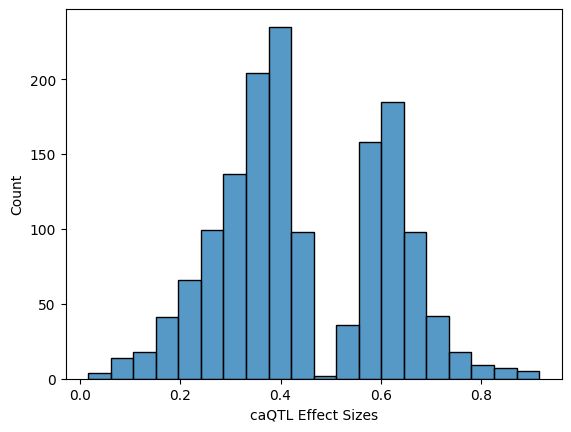

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(variants["Effect_size"])
plt.xlabel("caQTL Effect Sizes")

In [22]:
import numpy as np
from scipy.spatial.distance import jensenshannon
from scipy.stats import spearmanr
from sklearn.metrics import mutual_info_score

def crop_and_analyze(ref_tensor, alt_tensor, effect_sizes, max_crop_iterations=10):
    results = []
    
    for crop_size in range(max_crop_iterations):
        # Crop equally from both sides
        ref_cropped = ref_tensor[:, crop_size:-crop_size] if crop_size > 0 else ref_tensor
        alt_cropped = alt_tensor[:, crop_size:-crop_size] if crop_size > 0 else alt_tensor
        
        # Calculate pairwise JSDs
        jsds = np.array([jensenshannon(ref_crop, alt_crop) 
                         for ref_crop, alt_crop in zip(ref_cropped, alt_cropped)])
        
        # Compute correlation and mutual information
        spearman_corr, spearman_p = spearmanr(jsds, effect_sizes)
        mutual_info = mutual_info_score(
            pd.cut(jsds, bins=10).codes, 
            pd.cut(effect_sizes, bins=10).codes
        )
        
        results.append({
            'crop_size': crop_size,
            'spearman_corr': spearman_corr,
            'spearman_p': spearman_p,
            'mutual_info': mutual_info
        })
    
    return results

In [41]:
from scipy.spatial.distance import jensenshannon

ref_norm = [p / p.sum() for p in ref_predictions[1]]
alt_norm = [t / t.sum() for t in alt_predictions[1]]

# Compute JSD for PyTorch and CBP profiles
jsd = [jensenshannon(pytorch, target) 
               for pytorch, target in zip(alt_norm, ref_norm)]

In [92]:
jsd_cbp = [jensenshannon(alt, ref) 
               for alt, ref in zip(cbp_alt_outputs[0], cbp_ref_outputs[0])]

<Axes: >

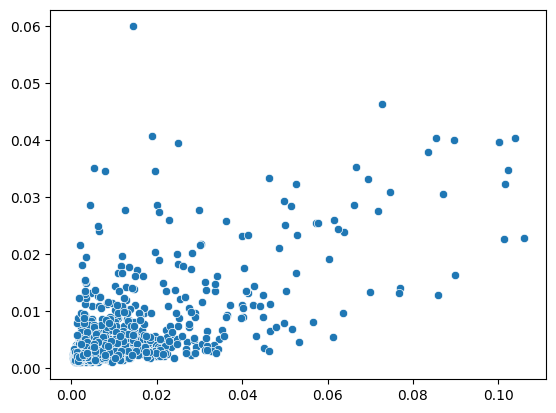

In [93]:
sns.scatterplot(x=jsd,y=jsd_cbp)

In [42]:
jensenshannon(ref_predictions[1][1],alt_predictions[1][1])

0.02707185698860562

In [43]:
jsd[1]

0.02707185698860562

<Axes: ylabel='Effect_size'>

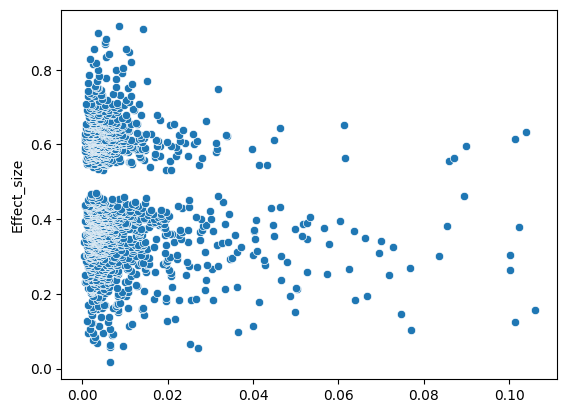

In [65]:
import seaborn as sns
sns.scatterplot(x=jsd,y=variants["Effect_size"])

## Try NULL set of random peaks with SNPs

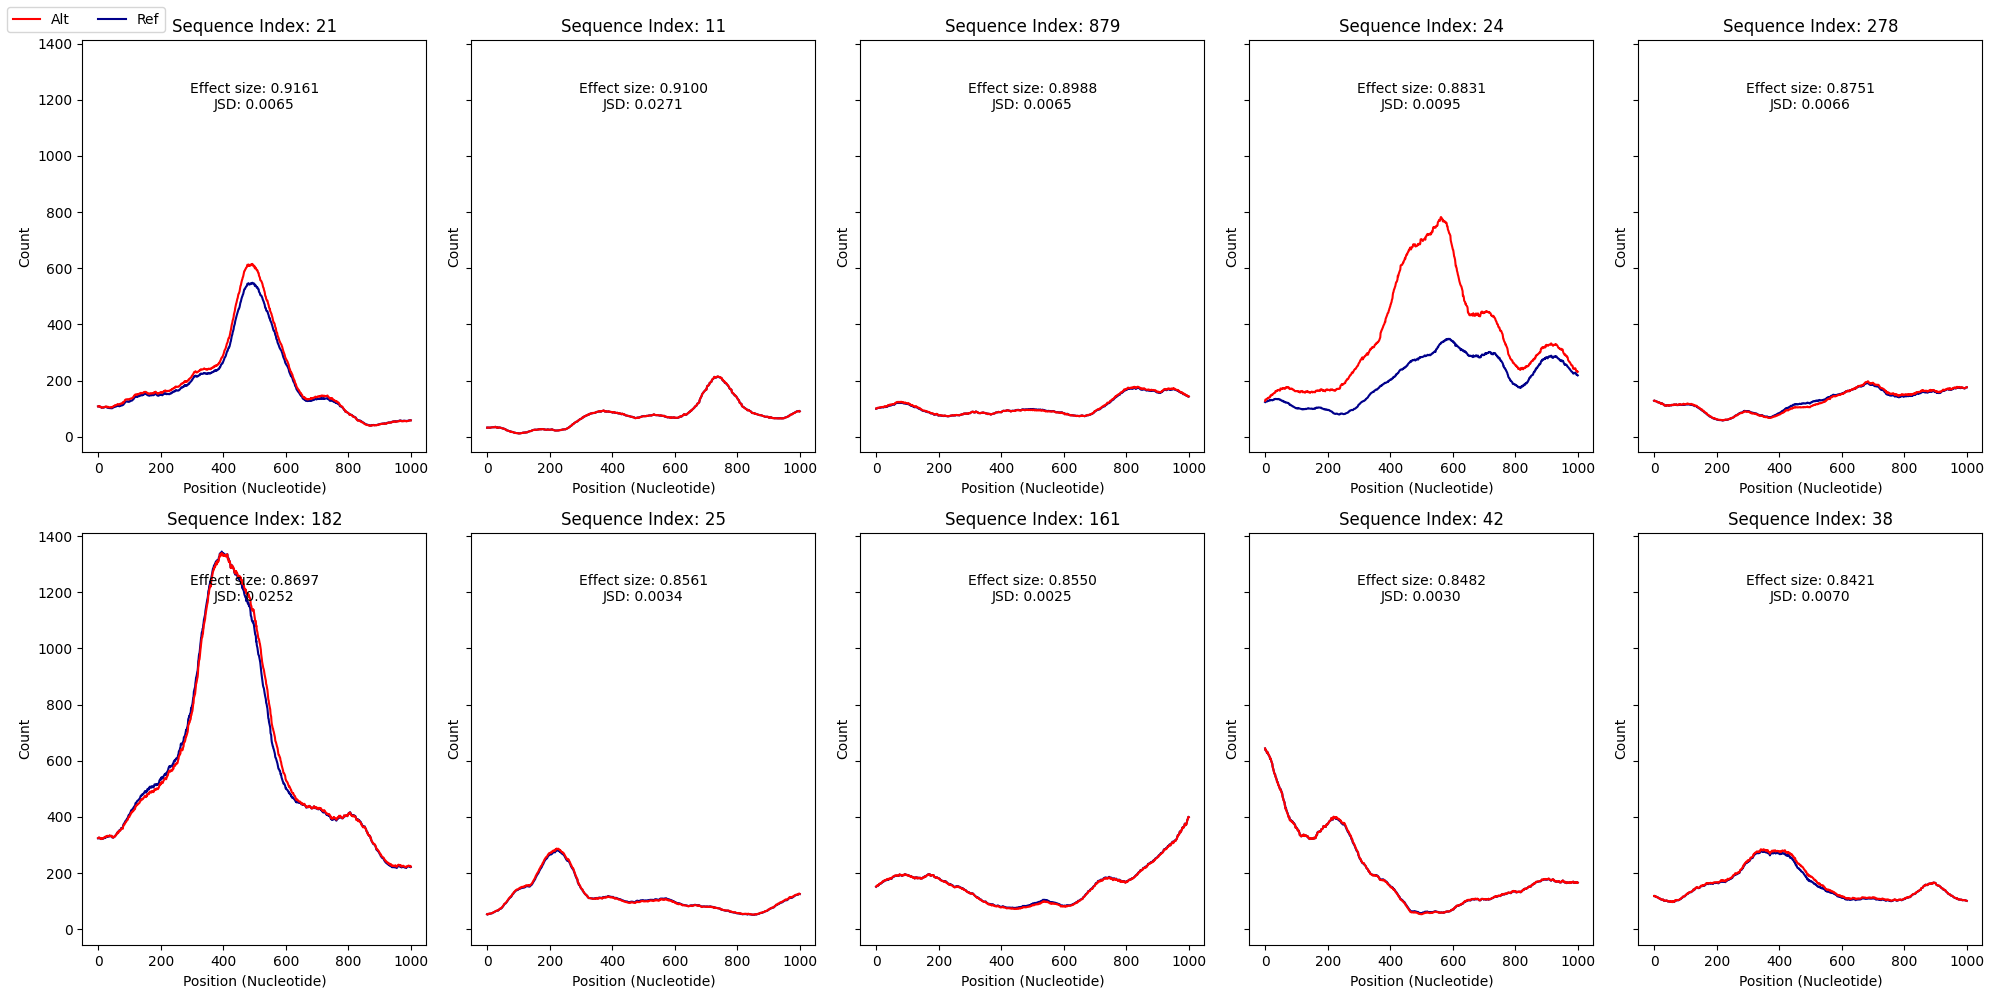

In [67]:
top_indexes = variants["Effect_size"].abs().nlargest(10).index

# Prepare the figure with a 2x5 grid for 10 plots
fig, axes = plt.subplots(2, 5, figsize=(20, 10), sharey=True)

axes = axes.flatten()

for i, idx in enumerate(top_indexes):
    # Plot the sequences
    axes[i].plot(ref_predictions[1][idx], label=f'Ref Seq {idx}', color='darkblue')
    axes[i].plot(alt_predictions[1][idx], label=f'Alt Seq {idx}', color='red')
    
    # Add title and labels
    axes[i].set_title(f'Sequence Index: {idx}')
    axes[i].set_xlabel('Position (Nucleotide)')
    axes[i].set_ylabel('Absolute Value')
    
    # Get the corresponding Effect size and JSD
    effect_size = variants["Effect_size"].abs().loc[idx]
    jsd_value = jsd[i]  # Assuming jsd_list corresponds to the same index order

    # Display the Effect size and JSD on the plot
    axes[i].text(0.5, 0.9, f"Effect size: {effect_size:.4f}\nJSD: {jsd_value:.4f}",
                 transform=axes[i].transAxes, ha='center', va='top', fontsize=10, color='black')

handles = [
plt.Line2D([0], [0], color="red", label='Alt'),
plt.Line2D([0], [0], color="darkblue", label='Ref')
]
fig.legend(handles=handles, loc='upper left', ncol=2, fontsize=10, frameon=True)
    #axes[i].grid()

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
cbp_alt_outputs

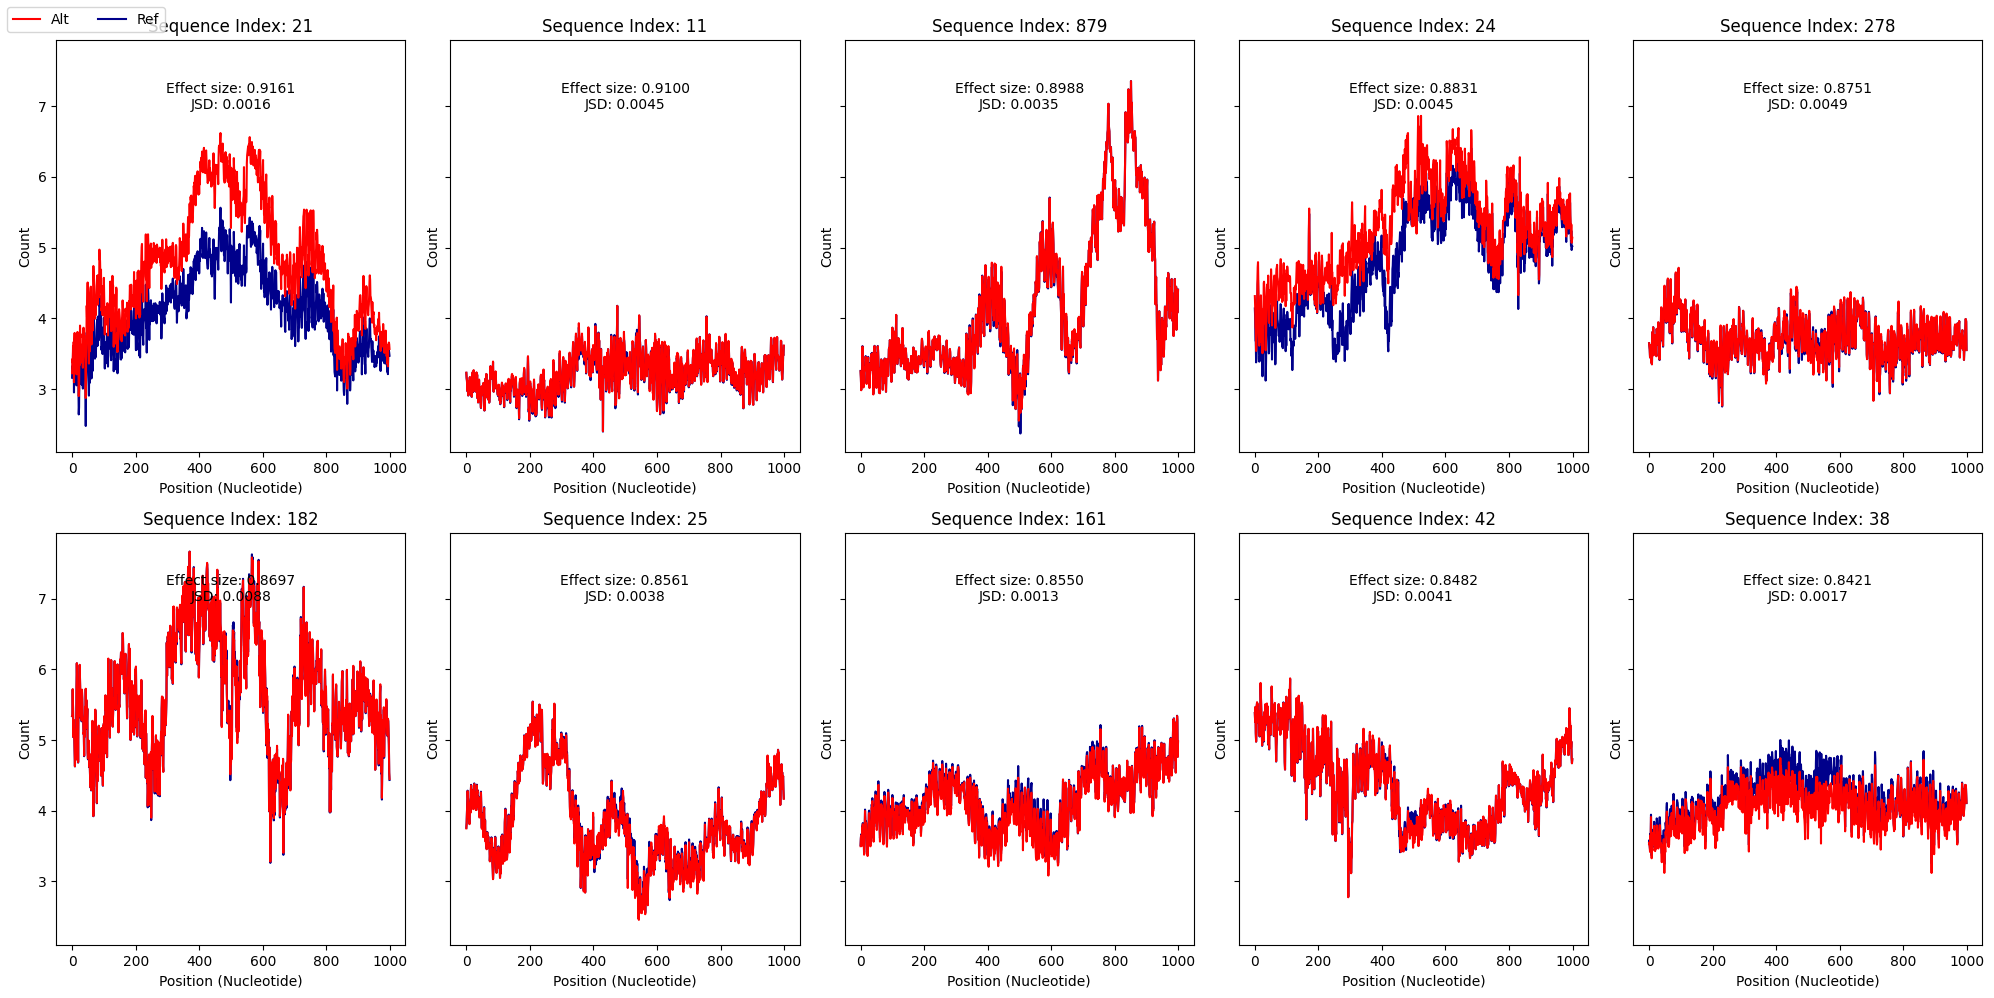

In [98]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10), sharey=True)

axes = axes.flatten()

for i, idx in enumerate(top_indexes):
    # Plot the sequences
    axes[i].plot(cbp_ref_outputs[0][idx], label=f'Ref Seq CBP {idx}', color='darkblue')
    axes[i].plot(cbp_alt_outputs[0][idx], label=f'Alt Seq CBP {idx}', color='red')
    
    # Add title and labels
    axes[i].set_title(f'Sequence Index: {idx}')
    axes[i].set_xlabel('Position (Nucleotide)')
    axes[i].set_ylabel('Count')
    
    # Get the corresponding Effect size and JSD
    effect_size = variants["Effect_size"].abs().loc[idx]
    jsd_value = jsd_cbp[i]  # Assuming jsd_list corresponds to the same index order

    # Display the Effect size and JSD on the plot
    axes[i].text(0.5, 0.9, f"Effect size: {effect_size:.4f}\nJSD: {jsd_value:.4f}",
                 transform=axes[i].transAxes, ha='center', va='top', fontsize=10, color='black')

handles = [
plt.Line2D([0], [0], color="red", label='Alt'),
plt.Line2D([0], [0], color="darkblue", label='Ref')
]
fig.legend(handles=handles, loc='upper left', ncol=2, fontsize=10, frameon=True)
    #axes[i].grid()

# Adjust layout
plt.tight_layout()
plt.show()

In [65]:
variants["Effect_size"].iloc[184]

0.276527

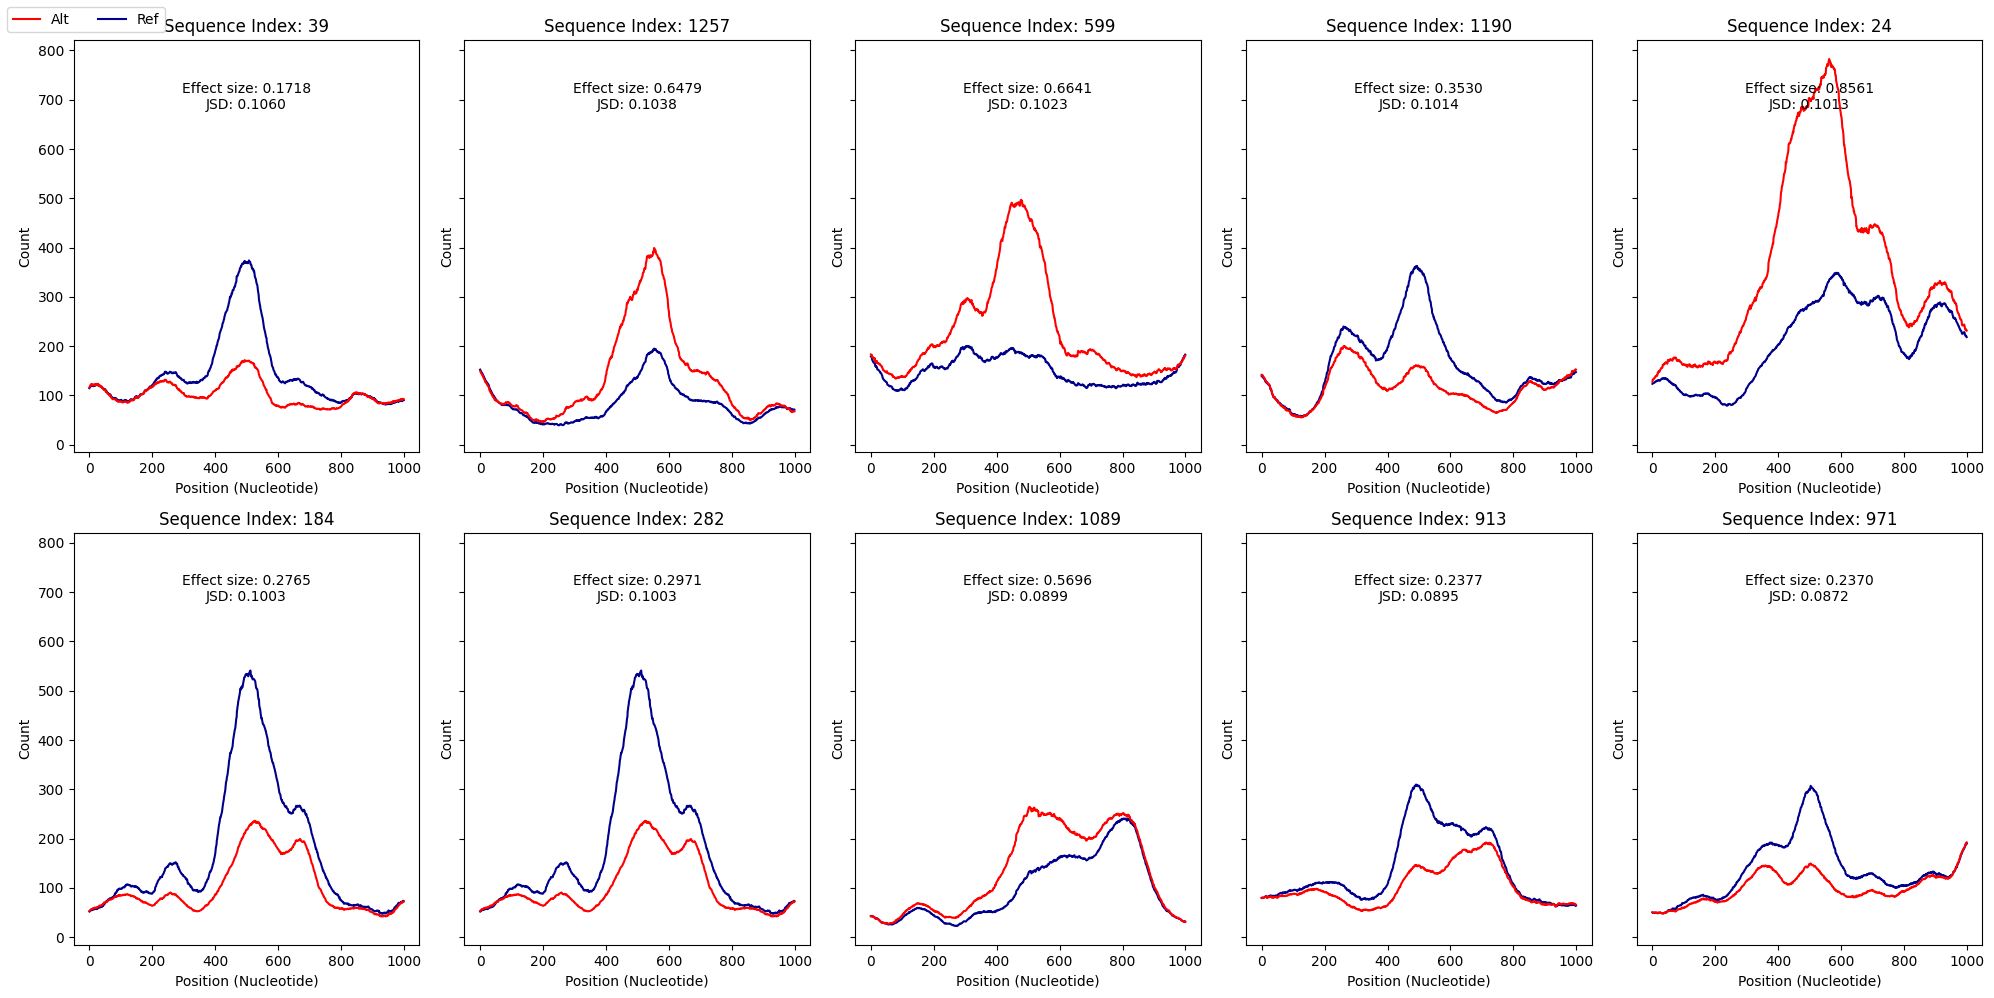

In [99]:

# Retrieve the top 10 indexes based on the JSD values
top_jsd_indexes = sorted(range(len(jsd)), key=lambda i: jsd[i], reverse=True)[:10]

# Prepare the figure with a 2x5 grid for 10 plots
fig, axes = plt.subplots(2, 5, figsize=(20, 10), sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, idx in enumerate(top_jsd_indexes):
    # Plot the sequences
    axes[i].plot(np.abs(ref_predictions[1][idx]), label=f'Ref Seq {idx}', color='darkblue')
    axes[i].plot(np.abs(alt_predictions[1][idx]), label=f'Alt Seq {idx}', color='red')
    
    # Add title and labels
    axes[i].set_title(f'Sequence Index: {idx}')
    axes[i].set_xlabel('Position (Nucleotide)')
    axes[i].set_ylabel('Count')
    
    # Get the corresponding Effect size and JSD
    effect_size = variants["Effect_size"].iloc[idx]
    jsd_value = jsd[idx]  # Get JSD value for this index

    # Display the Effect size and JSD on the plot
    axes[i].text(0.5, 0.9, f"Effect size: {effect_size:.4f}\nJSD: {jsd_value:.4f}",
                 transform=axes[i].transAxes, ha='center', va='top', fontsize=10, color='black')

    #axes[i].legend()
    #axes[i].grid()

handles = [
plt.Line2D([0], [0], color="red", label='Alt'),
plt.Line2D([0], [0], color="darkblue", label='Ref')
]
fig.legend(handles=handles, loc='upper left', ncol=2, fontsize=10, frameon=True)
    #axes[i].grid()

plt.tight_layout()
plt.show()


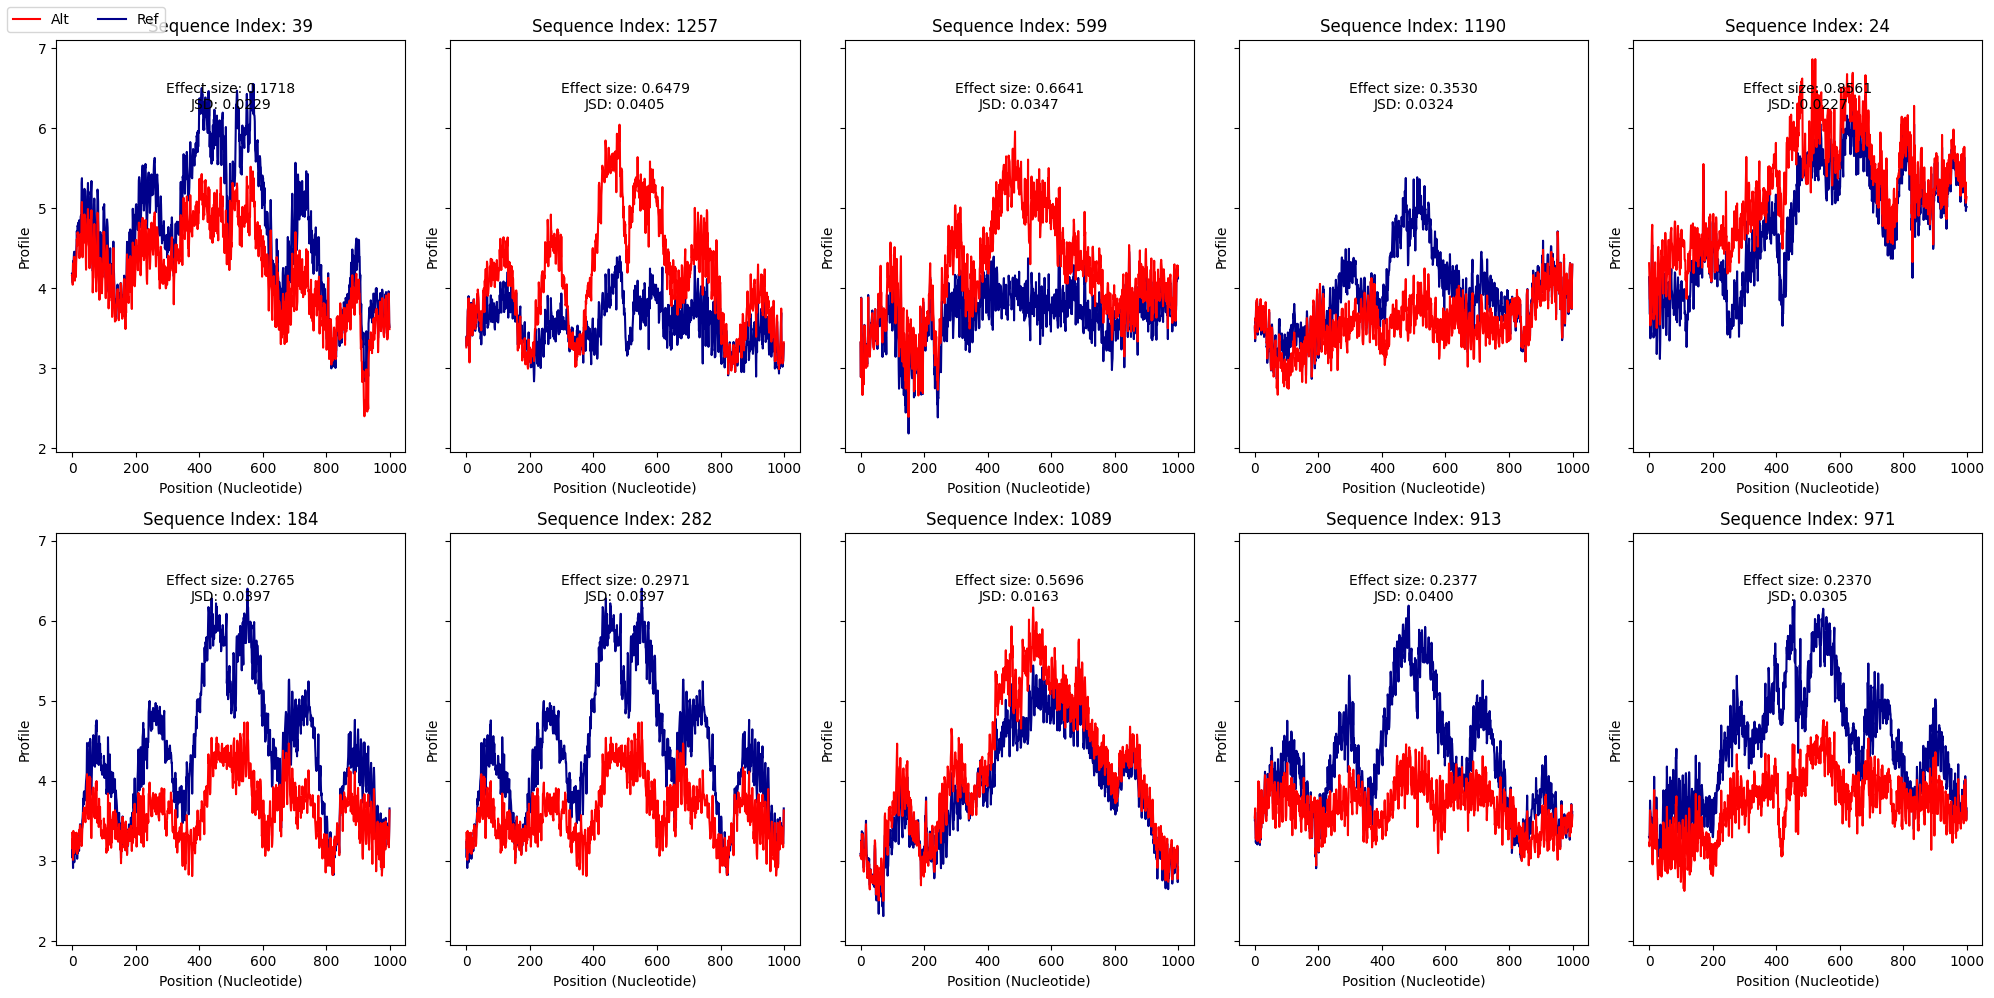

In [101]:

# Retrieve the top 10 indexes based on the JSD values
top_jsd_indexes = sorted(range(len(jsd)), key=lambda i: jsd[i], reverse=True)[:10]

# Prepare the figure with a 2x5 grid for 10 plots
fig, axes = plt.subplots(2, 5, figsize=(20, 10), sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, idx in enumerate(top_jsd_indexes):
    # Plot the sequences
    axes[i].plot(cbp_ref_outputs[0][idx], label=f'Ref Seq {idx}', color='darkblue')
    axes[i].plot(cbp_alt_outputs[0][idx], label=f'Alt Seq {idx}', color='red')
    
    # Add title and labels
    axes[i].set_title(f'Sequence Index: {idx}')
    axes[i].set_xlabel('Position (Nucleotide)')
    axes[i].set_ylabel('Profile')
    
    # Get the corresponding Effect size and JSD
    effect_size = variants["Effect_size"].iloc[idx]
    jsd_value = jsd_cbp[idx]  # Get JSD value for this index

    # Display the Effect size and JSD on the plot
    axes[i].text(0.5, 0.9, f"Effect size: {effect_size:.4f}\nJSD: {jsd_value:.4f}",
                 transform=axes[i].transAxes, ha='center', va='top', fontsize=10, color='black')

    #axes[i].legend()
    #axes[i].grid()

handles = [
plt.Line2D([0], [0], color="red", label='Alt'),
plt.Line2D([0], [0], color="darkblue", label='Ref')
]
fig.legend(handles=handles, loc='upper left', ncol=2, fontsize=10, frameon=True)
    #axes[i].grid()

plt.tight_layout()
plt.show()


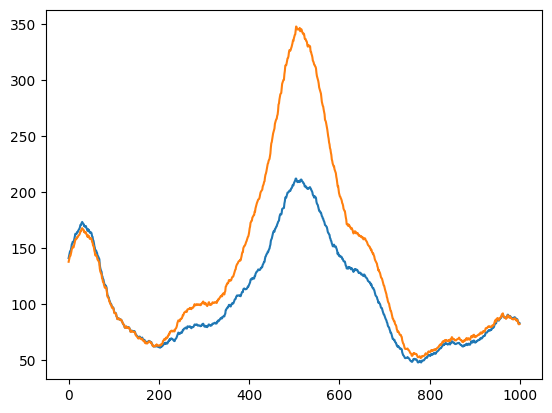

In [53]:
plt.plot(ref_predictions[1][75])
plt.plot(alt_predictions[1][75])

In [24]:
ref_predictions[1].shape

torch.Size([1476, 1000])

In [155]:
cbp_ref_outputs

[array([[3.4114225, 3.4187899, 3.4716287, ..., 2.8385003, 2.9279623,
         2.9891999],
        [3.7379293, 3.9910083, 4.032834 , ..., 5.813506 , 5.5616875,
         5.4073772],
        [4.2675915, 4.0931544, 4.4208975, ..., 4.169689 , 4.1026473,
         4.1036253],
        ...,
        [4.0185165, 3.9032948, 3.9334774, ..., 5.8669243, 5.8337917,
         5.798212 ],
        [3.092481 , 3.186895 , 3.3320394, ..., 4.6199117, 4.4573665,
         4.5518   ],
        [3.6328628, 3.5135586, 3.457959 , ..., 4.1138506, 4.1342196,
         4.0619946]], dtype=float32),
 array([[5.8049436],
        [8.484888 ],
        [8.577386 ],
        ...,
        [7.7782373],
        [7.680562 ],
        [6.8814144]], dtype=float32)]

In [159]:
import torch
import numpy as np
from scipy.stats import spearmanr
from sklearn.metrics import mutual_info_score
from scipy.spatial.distance import jensenshannon

def crop_and_analyze_tensors(ref_tensor, alt_tensor, cbp_ref, cbp_alt, effect_sizes):
    """
    Iteratively crop tensors from both sides and analyze similarity
    
    Parameters:
    - ref_tensor: Reference predictions tensor (1476, 1000)
    - alt_tensor: Alternate predictions tensor (1476, 1000)
    - effect_sizes: Corresponding caQTL effect sizes
    
    Returns:
    - Dictionary with cropping results
    """
    results = {}
    max_crop = ref_tensor.shape[1] // 2  # Half tensor length
    
    for crop_size in range(0, max_crop + 1, 10):  # Iterate with step of 10
        # Crop tensors symmetrically
        ref_cropped = ref_tensor[:, crop_size:-crop_size] if crop_size > 0 else ref_tensor
        alt_cropped = alt_tensor[:, crop_size:-crop_size] if crop_size > 0 else alt_tensor
        ref_cropped_cbp = cbp_ref[:, crop_size:-crop_size] if crop_size > 0 else cbp_ref
        alt_cropped_cbp = cbp_alt[:, crop_size:-crop_size] if crop_size > 0 else cbp_alt

        # Calculate pairwise JSDs
        jsds = [jensenshannon(ref_row, alt_row) for ref_row, alt_row in zip(ref_cropped, alt_cropped)]
        jsds_cbp = [jensenshannon(ref_row, alt_row) for ref_row, alt_row in zip(ref_cropped_cbp, alt_cropped_cbp)]
        
        # Calculate correlations
        spearman_corr, spearman_p = spearmanr(jsds, effect_sizes)
        spearman_corr_cbp, spearman_p_cbp = spearmanr(jsds_cbp, effect_sizes)
        
        # Discretize JSDs and effect sizes using histograms
        num_bins = 20
        jsd_bins = np.histogram(jsds, bins=num_bins)[0]
        jsd_bins_cbp = np.histogram(jsds_cbp, bins=num_bins)[0]
        effect_bins = np.histogram(effect_sizes, bins=num_bins)[0]
        
        # Calculate mutual information
        mi = mutual_info_score(jsd_bins, effect_bins)
        mi_cbp = mutual_info_score(jsd_bins_cbp, effect_bins)
        
        results[crop_size] = {
            'spearman_correlation': spearman_corr,
            'spearman_correlation_cbp': spearman_corr_cbp,
            'spearman_p_value': spearman_p,
            'spearman_p_value_cbp': spearman_p_cbp,
            'mutual_information': mi,
            'mutual_information_cbp': mi_cbp,
            'mean_jsd': np.mean(jsds),
            'mean_jsd_cbp': np.mean(jsds_cbp)
        }
    
    return results

In [161]:
cropping_results = crop_and_analyze_tensors(ref_predictions[1], alt_predictions[1], cbp_ref_outputs[0], cbp_alt_outputs[0], variants.Effect_size)

/wynton/home/corces/vishvak/miniforge3/envs/chrombpnet/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [162]:
cropping_df = pd.DataFrame.from_dict(cropping_results)

In [163]:
cropping_df = cropping_df.T
cropping_df.head()

,spearman_correlation,spearman_correlation_cbp,spearman_p_value,spearman_p_value_cbp,mutual_information,mutual_information_cbp,mean_jsd,mean_jsd_cbp
0,0.000598,0.004093,0.981679,0.875154,2.484367,2.345737,0.009582,0.004614
10,0.000791,0.004012,0.975776,0.877614,2.388890,2.441215,0.009569,0.004618
20,0.000785,0.004026,0.975957,0.877193,2.345737,2.276423,0.009556,0.004625
30,0.000811,0.004265,0.975157,0.869968,2.510529,2.510529,0.009542,0.004635
40,0.000940,0.004341,0.971223,0.867668,2.276423,2.510529,0.009529,0.004651


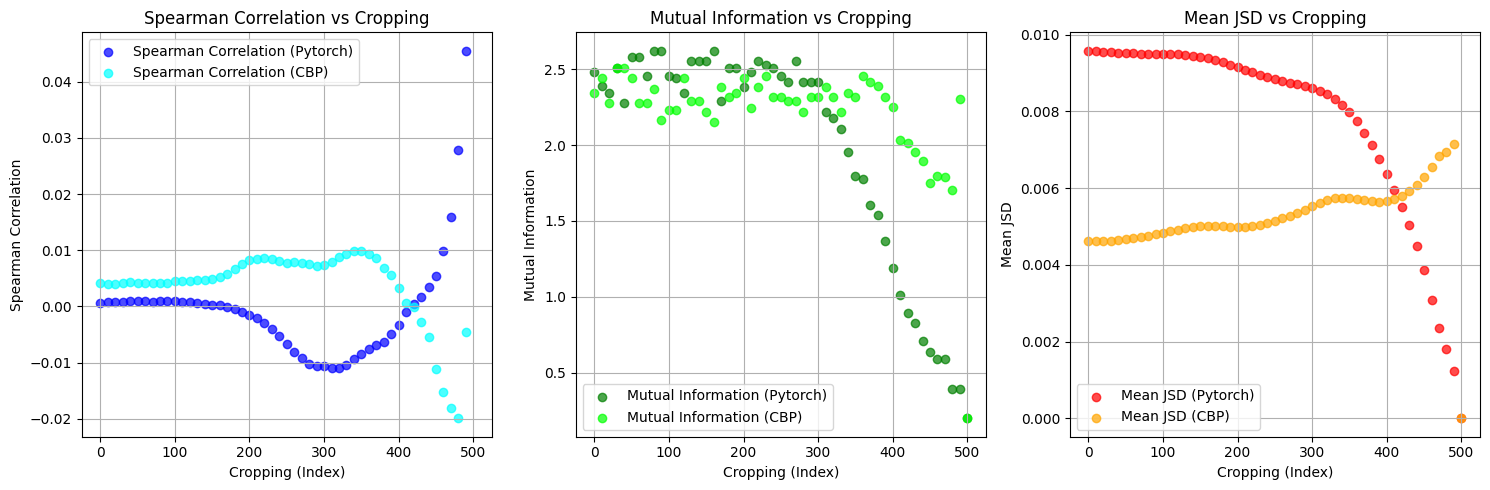

In [165]:

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

# Spearman correlation vs cropping
axes[0].scatter(cropping_df.index, cropping_df['spearman_correlation'], color='blue', label='Spearman Correlation (Pytorch)', alpha=0.7)
axes[0].scatter(cropping_df.index, cropping_df['spearman_correlation_cbp'], color='cyan', label='Spearman Correlation (CBP)', alpha=0.7)
axes[0].set_title('Spearman Correlation vs Cropping')
axes[0].set_xlabel('Cropping (Index)')
axes[0].set_ylabel('Spearman Correlation')
axes[0].grid()
axes[0].legend()

# Mutual information vs cropping
axes[1].scatter(cropping_df.index, cropping_df['mutual_information'], color='green', label='Mutual Information (Pytorch)', alpha=0.7)
axes[1].scatter(cropping_df.index, cropping_df['mutual_information_cbp'], color='lime', label='Mutual Information (CBP)', alpha=0.7)
axes[1].set_title('Mutual Information vs Cropping')
axes[1].set_xlabel('Cropping (Index)')
axes[1].set_ylabel('Mutual Information')
axes[1].grid()
axes[1].legend()

# Mean JSD vs cropping
axes[2].scatter(cropping_df.index, cropping_df['mean_jsd'], color='red', label='Mean JSD (Pytorch)', alpha=0.7)
axes[2].scatter(cropping_df.index, cropping_df['mean_jsd_cbp'], color='orange', label='Mean JSD (CBP)', alpha=0.7)
axes[2].set_title('Mean JSD vs Cropping')
axes[2].set_xlabel('Cropping (Index)')
axes[2].set_ylabel('Mean JSD')
axes[2].grid()
axes[2].legend()

plt.tight_layout()
plt.show()

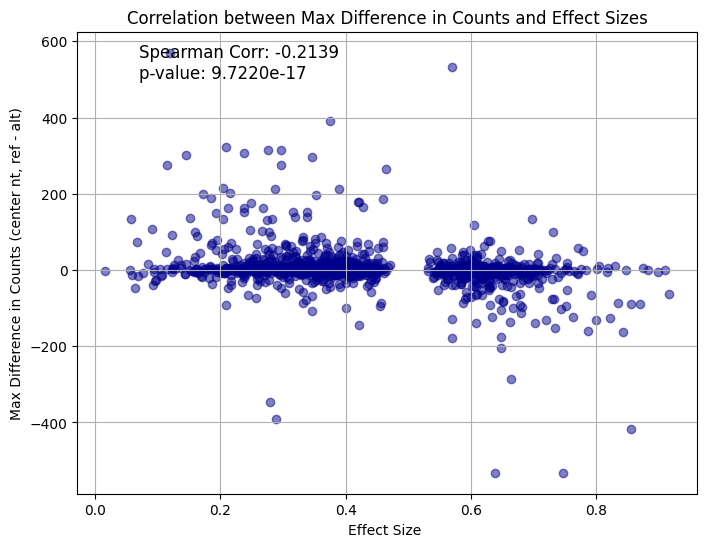

In [149]:

spearman_corr, spearman_p = spearmanr(ref_predictions[1][:,500] - alt_predictions[1][:,500], variants["Effect_size"])

# Plot the correlation
plt.figure(figsize=(8, 6))
plt.scatter(y=ref_predictions[1][:,500] - alt_predictions[1][:,500], x=np.abs(variants["Effect_size"]), alpha=0.5, color='darkblue')
plt.title("Correlation between Max Difference in Counts and Effect Sizes")
plt.ylabel("Max Difference in Counts (center nt, ref - alt)")
plt.xlabel("Effect Size ")
plt.text(0.1, 0.9, f'Spearman Corr: {spearman_corr:.4f}\np-value: {spearman_p:.4e}', 
         transform=plt.gca().transAxes, fontsize=12, color='black')
plt.grid(True)
plt.show()


In [141]:
spearmanr(ref_predictions[1][:,499] - alt_predictions[1][:,499], variants["Effect_size"])


SignificanceResult(statistic=-0.21404582503214736, pvalue=9.336711290201241e-17)

In [144]:
spearmanr(ref_predictions[1][:,610] - alt_predictions[1][:,610], variants["Effect_size"])


SignificanceResult(statistic=-0.20166823843917392, pvalue=5.2084177056037665e-15)

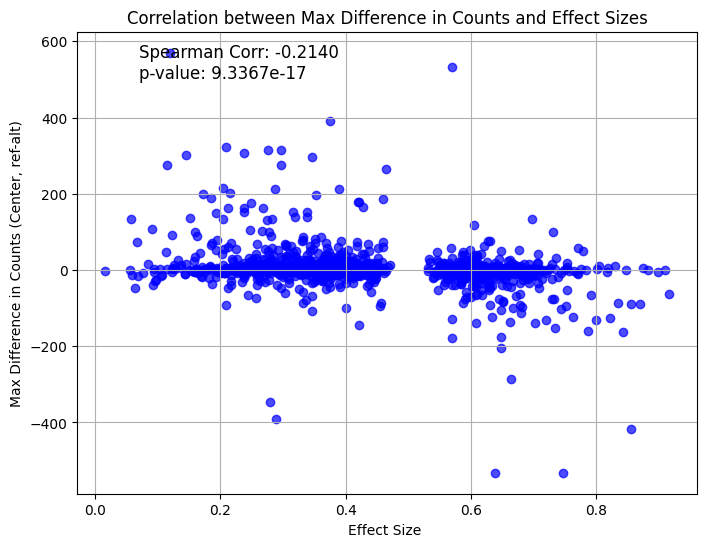

In [140]:
spearman_corr, spearman_p = spearmanr(ref_predictions[1][:,499] - alt_predictions[1][:,499], variants["Effect_size"])

# Plot the correlation
plt.figure(figsize=(8, 6))
plt.scatter(y=ref_predictions[1][:,500] - alt_predictions[1][:,500], x=np.abs(variants["Effect_size"]), alpha=0.7, color='blue')
plt.title("Correlation between Max Difference in Counts and Effect Sizes")
plt.ylabel("Max Difference in Counts (Center, ref-alt)")
plt.xlabel("Effect Size ")
plt.text(0.1, 0.9, f'Spearman Corr: {spearman_corr:.4f}\np-value: {spearman_p:.4e}', 
         transform=plt.gca().transAxes, fontsize=12, color='black')
plt.grid(True)
plt.show()

In [ ]:

# Compute the Spearman correlation with effect sizes
spearman_corr, spearman_p = spearmanr(max_diff, np.abs(variants["Effect_size"]))

# Plot the correlation
plt.figure(figsize=(8, 6))
plt.scatter(max_diff, np.abs(variants["Effect_size"]), alpha=0.7, color='blue')
plt.title("Correlation between Max Difference in Counts and Effect Sizes")
plt.xlabel("Max Difference in Counts (Center vs Rest)")
plt.ylabel("Effect Size (Absolute Value)")
plt.text(0.1, 0.9, f'Spearman Corr: {spearman_corr:.4f}\np-value: {spearman_p:.4e}', 
         transform=plt.gca().transAxes, fontsize=12, color='black')
plt.grid(True)
plt.show()
